# Assignment 2: Computational methods in Finance
## UNI: cl4249
## Charles Laferte

Use explicit-implicit finite difference scheme covered during the lecture to solve the PIDE.
Calculate UOC option premium in this framework for the following parameters: spot price, S0 = $1900; strike price K = 2000;
upper barrier B = 2200, risk-free interest rate, r = 0.25%; dividend rate, q = 1.5%; maturity, T = 0.5 year; σ = 25%, ν = 0.31,
θ = −0.25, and Y = 0.4.

In [1]:
import math
import numpy as np
from mpmath import nsum, exp, inf
import scipy.special as sc
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import time

from mpl_toolkits.mplot3d import Axes3D


Let's set the different parameters we will use in this pricing.

In [2]:
N = 900
M = 30

S = 1900
K = 2000

Bound = 2200
rate = 0.0025
div = 0.015
T = 1/2
sig = 0.25

nu = 0.31
theta = -0.25
Y = 0.4
alpha = Y


xmin = 600
xmax = Bound

dx = (np.log(xmax)-np.log(xmin))/N
dt = T/M

We can note the volatility is quite important here.

We then need to set the values for lambda_p and lambda_n as defined here.

In [3]:
lbda_n = math.sqrt(theta * theta / (sig**4) + 2 / (nu * sig**2)) + theta / (sig **2)
lbda_p = math.sqrt(theta * theta / (sig**4) + 2 / (nu * sig**2)) - theta / (sig **2)

Using the different methods seen in both chapter 4 & 5, we need to define the following function.

In [4]:
def g1(x):
    return integrate.quad(lambda z: np.exp(-z)/(z**alpha),x,np.inf)[0]

def g2(x):
    return integrate.quad(lambda z: np.exp(-z)/z**(alpha+1),x,np.inf)[0]

def omeg(e):
    pos = (lbda_p**Y*g2(lbda_p*e)-(lbda_p-1)**Y*g2((lbda_p-1)*e))/nu
    neg = (lbda_n**Y*g2(lbda_n*e)-(lbda_n-1)**Y*g2((lbda_n+1)*e))/nu
    return pos + neg

def sigma_2(Y,dx, lbda_p, lbda_n,v):
    sig = (-(lbda_p*dx)**(1-Y)*np.exp(-lbda_p*dx)+(1-Y)*(g1(0)-g1(lbda_p*dx)))*lbda_p**(Y-2)/v
    sig+= (-(lbda_n*dx)**(1-Y)*np.exp(-lbda_n*dx)+(1-Y)*(g1(0)-g1(lbda_n*dx)))*lbda_n**(Y-2)/v
    return sig

We can compute several vectors in advance to fasten the computations.

In [5]:
g1_n_diff = [0]
g1_p_diff = [0]
g2_n_diff = [0]
g2_p_diff = [0]

for k in range(1,N+1):
    g1_n_diff.append(g1(k*dx*lbda_n)-g1((k+1)*dx*lbda_n))
    g1_p_diff.append(g1(k*dx*lbda_p)-g1((k+1)*dx*lbda_p))
    g2_n_diff.append(g2(k*dx*lbda_n)-g2((k+1)*dx*lbda_n))
    g2_p_diff.append(g2(k*dx*lbda_p)-g2((k+1)*dx*lbda_p))

In [6]:
def tridiag(LL, DD, UU, B, NN):
    '''
    This is a Python function called "tridiag" that solves a system of linear equations 
    with a tridiagonal coefficient matrix. The function takes five input parameters: 
    LL, DD, UU, B, and NN. Here's what each of these parameters represents:

    LL, DD, and UU are arrays representing the lower, diagonal, and upper coefficients of the tridiagonal matrix,
    respectively. Specifically, LL[i], DD[i], 
    and UU[i] represent the coefficients of the (i, i-1), (i, i), and (i, i+1) elements of the matrix, respectively.
    B is an array representing the right-hand side of the system of equations.
    '''
    
    L = np.empty(NN+1)
    D = np.empty(NN+1)
    U = np.empty(NN+1)
    for i in range(1,NN+1):
        L[i] = LL[i]
        D[i] = DD[i]
        U[i] = UU[i]
    for i in range(NN-1, 0, -1):
        Xmult = U[i] / D[i+1]
        D[i] = D[i] - Xmult * L[i+1]
        B[i] = B[i] - Xmult * B[i+1]
    B[1] = B[1] / D[1]
    Ic = 1
    for i in range(Ic+1, NN+1):
        B[i] = (B[i] - L[i] * B[i-1]) / D[i]
    return 

Option price using the explicit-implicit Finite Difference method: for strike 2000 the option premium is 3.9547
Execution time for pricing and preparing the plot was 90.46032 seconds


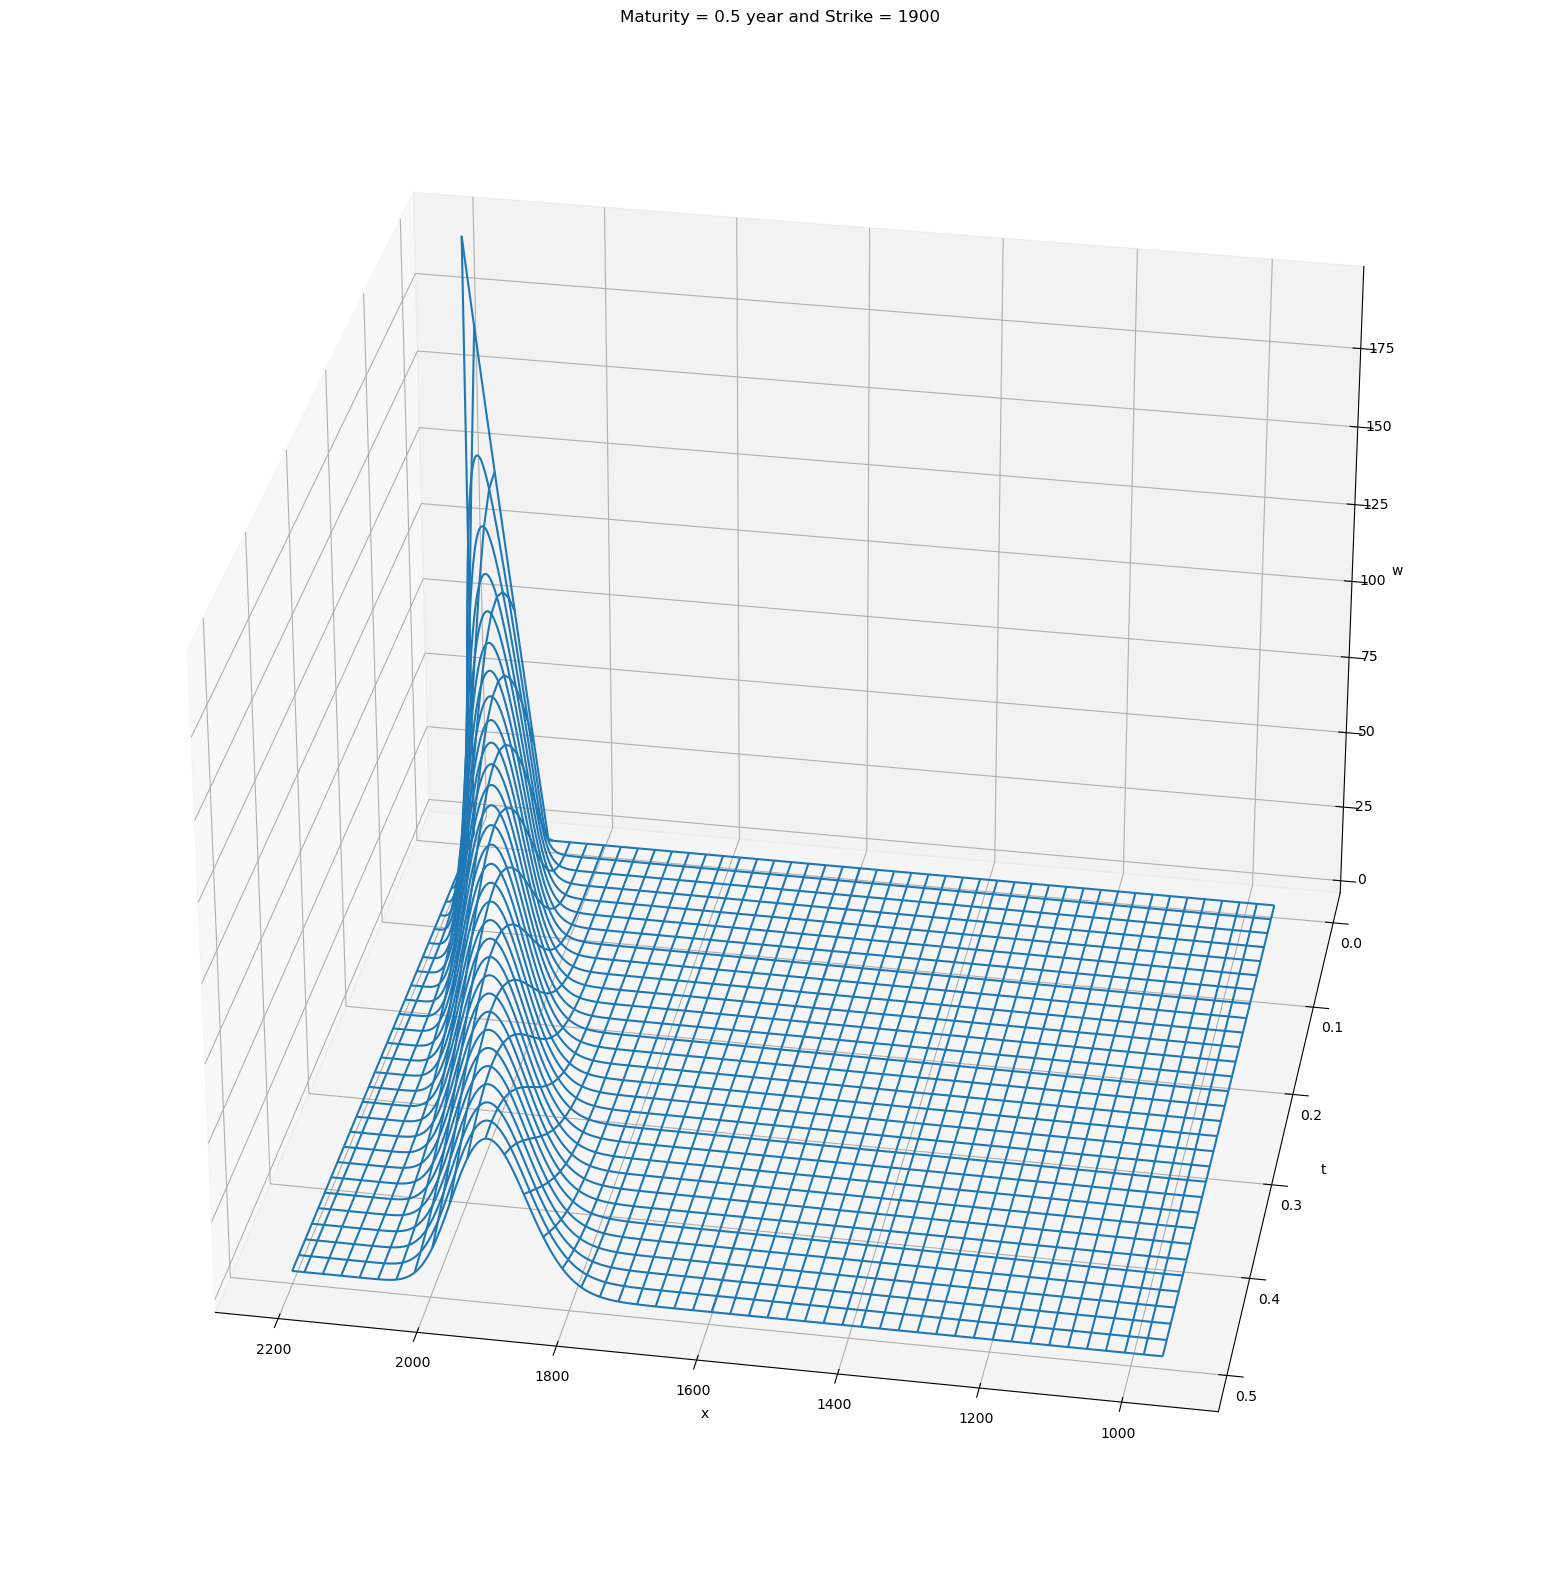

In [7]:
start_time = time.time()

L = np.empty((N))
U = np.empty((N))
D = np.empty((N))
B = np.empty((N))


exp_n = np.zeros(N)
exp_p = np.zeros(N)

ei_n = np.zeros(N)
ei_p = np.zeros(N)

A = np.zeros(M)
r = np.zeros(M)
q = np.zeros(M)

omega = np.log(1-theta*nu-sig*sig*nu/2)/nu

cn = dt/(lbda_n*nu*dx)
cp = dt/(lbda_p*nu*dx)

c = dt/nu

#Bp is for U
sigma2_dx = sigma_2(Y,dx, lbda_p, lbda_n,nu)
Bp  = sigma2_dx*dt *(1/(2*dx**2)-1/(2*dx))        
#Bn is for L
Bn  = sigma2_dx*dt *(1/(2*dx**2)+1/(2*dx))

x = np.empty(N+1)
W = np.empty(N+1)
Wmatrix=[]

for i in range(N+1):
    x[i] = np.log(xmin)+i*dx
    if i == N:
        W[i] = 0
    else:
        if np.exp(x[i]) > K:
            W[i] = np.exp(x[i])-K
        else:
            W[i] = 0.0

Wmatrix.append(W.tolist())

for j in range(M-1, -1, -1):
    r[j] = rate
    q[j] = div
    A[j] = (r[j]-q[j]+omega)*dt/dx
    for i in range(1, N):
        B[i] = W[i]

    for i in range(1, N):
        if i == 1:
            D[i] = 1 + r[j]*dt + Bp + Bn + dt*((lbda_n**Y*g2(i*dx*lbda_n)+lbda_p**Y*g2((N-i)*dx*lbda_p)))/nu
            U[i] = -A[j] - Bp

            for k in range(1, N-i):
                B[i] += lbda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g2_p_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lbda_p**(1-Y)*dx)*(g1_p_diff[k])

        elif i == N-1:
            L[i] = A[j] - Bn
            D[i] = 1 + r[j]*dt + Bp + Bn + dt*((lbda_n**Y*g2(i*dx*lbda_n)+lbda_p**Y*g2((N-i)*dx*lbda_p)))/nu

            for k in range(1, i):
                B[i] += lbda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_n_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lbda_n**(1-Y)*dx)*(g1_n_diff[k])

        else:
            L[i] =  A[j] - Bn
            D[i] =  1 + r[j]*dt + Bp + Bn + dt*((lbda_n**Y*g2(i*dx*lbda_n)+lbda_p**Y*g2((N-i)*dx*lbda_p)))/nu
            U[i] = -A[j] - Bp

            for k in range(1, N-i):
                B[i] += lbda_p**Y*(W[i+k]-W[i]-k*(W[i+k+1]-W[i+k]))*(g2_p_diff[k])
                B[i] += (W[i+k+1]-W[i+k])/(lbda_p**(1-Y)*dx)*(g1_p_diff[k])

            for k in range(1, i):
                B[i] += lbda_n**Y*(W[i-k]-W[i]-k*(W[i-k-1]-W[i-k]))*(g2_n_diff[k])
                B[i] += (W[i-k-1]-W[i-k])/(lbda_n**(1-Y)*dx)*(g1_n_diff[k])

        B[i] += K*lbda_n**Y*g2(i*dx*lbda_n) - np.exp(x[i])*(lbda_n+1)**Y*g2(i*dx*(lbda_n+1))
    

    tridiag(L,D,U,W,N-1)
    Wmatrix.append(W.tolist())

ir = 0
for i in range(N):
    if x[i] > np.log(S):
        ir = i 
        break

UOC = (W[ir]-W[ir-1])*(np.log(S)-x[ir-1])/dx+ W[ir-1]


print(60*'=')
print("Option price using the explicit-implicit Finite Difference method: for strike %s the option premium \
is %6.4f" % (2000,UOC))
elapsed_time = time.time() - start_time
print('Execution time for pricing and preparing the plot was %0.5f seconds' % elapsed_time)
print(60*'=')

n = 200
# Setting the values for x and y axes
x = np.linspace(xmin, xmax, N+1)
t = np.linspace(0, T, M+1)
X, Y = np.meshgrid(x[n:],t)
Z = np.array(Wmatrix)
Z = Z[:,n:]

# Create 3D figure
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(111, projection='3d')

# Plot surface with X, Y, and Z values
#ax.plot_surface(X, Y, Z, cmap='viridis')
#ax.scatter(X, Y, Z)#, cmap='viridis')
ax.plot_wireframe(X, Y, Z)

# Add axis labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('w')
ax.set_title('Maturity = 0.5 year and Strike = 1900')

# Manually adjust the viewing angle
ax.view_init(30,100)

# Show the plot
plt.show()


We can note there are several reasons that confort the price found. The price is low because the volatility is high. This reduces the probability of the option ending up in the money, which reduces the option's price. Then, the maturity is short. The shorter time frame reduces the likelihood of the underlying asset reaching the strike price, which leads to a lower price for the option.